# Perform time series prediction - RNN

In this project you will perform time series prediction using a Recurrent Neural Network regressor.  In particular you will re-create the figure shown in the notes - where the stock price of Apple was forecasted (or predicted) 7 days in advance. 

The particular network architecture we will employ for our RNN is known as  [Long Term Short Memory (LSTM)](https://en.wikipedia.org/wiki/Long_short-term_memory), which helps significantly avoid technical problems with optimization of RNNs.  

In [17]:
### Load in necessary libraries for data input and normalization
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from my_answers import *

### load in and normalize the dataset
dataset_Ori = np.loadtxt('/home/johan/repos/GitHub/Time-SeriesForecasting/Data/apple_prices.csv')
dataset = np.loadtxt('/home/johan/repos/GitHub/Time-SeriesForecasting/Data/normalized_apple_prices.csv')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


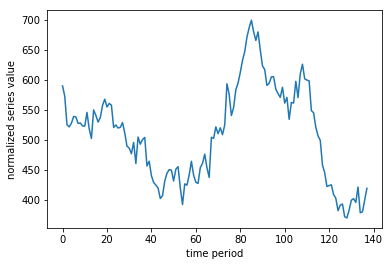

In [2]:
# lets take a look at our time series
plt.plot(dataset_Ori)
plt.xlabel('time period')
plt.ylabel('normalized series value')

Lets take a quick look at the (normalized) time series we'll be performing predictions on.

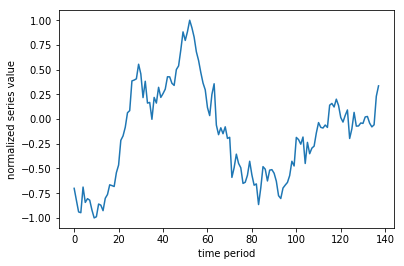

In [3]:
# lets take a look at our time series
plt.plot(dataset)
plt.xlabel('time period')
plt.ylabel('normalized series value')

**Cutting our time series into sequences**

Remember, our time series is a sequence of numbers that we can represent in general mathematically as 

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series.  In order to apply our RNN I treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.

<img src="Img/dnn2rnn.png" width=200 height=200/>

<img src="Img/time_2.gif" width=400 height=400/>


For example - using a window of size T = 5 (as illustrated in the gif above) I produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Notice here that each input is a sequence (or vector) of length 5 (and in general has length equal to the window size T) while each corresponding output is a scalar value.  Notice also how given a time series of length P and window size T = 5 as shown above, we created P - 5  input/output pairs.  More generally, for a window size T we create P - T such pairs.

In [20]:
#You can test your function on the list of odd numbers given below
odd_nums = np.array([1,3,5,7,9,11,13])

Here is a hard-coded solution for odd_nums.  You can compare its results with what you get from your **window_transform_series** implementation.

In [5]:
# run a window of size 2 over the odd number sequence and display the results
window_size = 2

X = []
X.append(odd_nums[0:2])
X.append(odd_nums[1:3])
X.append(odd_nums[2:4])
X.append(odd_nums[3:5])
X.append(odd_nums[4:6])

y = odd_nums[2:]

X = np.asarray(X)
y = np.asarray(y)
y = np.reshape(y, (len(y),1)) #optional

assert(type(X).__name__ == 'ndarray')
assert(type(y).__name__ == 'ndarray')
assert(X.shape == (5,2))
assert(y.shape in [(5,1), (5,)])

# print out input/output pairs --> here input = X, corresponding output = y
print ('--- the input X will look like ----')
print (X)

print ('--- the associated output y will look like ----')
print (y)

--- the input X will look like ----
[[ 1  3]
 [ 3  5]
 [ 5  7]
 [ 7  9]
 [ 9 11]]
--- the associated output y will look like ----
[[ 5]
 [ 7]
 [ 9]
 [11]
 [13]]


Again - you can check that your completed **window_transform_series** function works correctly by trying it on the odd_nums sequence - you should get the above output.

In [6]:
### DONE: implement the function window_transform_series in the file my_answers.py
from my_answers import window_transform_series

With this function in place apply it to the series in the Python cell below.  We use a window_size = 7 for these experiments.

In [7]:
# window the data using your windowing function
window_size = 7
X,y = window_transform_series(series = dataset,window_size = window_size)

**Splitting into training and testing sets**

Note how here I am **not** splitting the dataset *randomly* as one typically would do when validating a regression model.  This is because our input/output pairs *are related temporally*.  

I want to train on one solid chunk of the series (in this case, the first full 2/3 of it), and validate on a later chunk (the last 1/3) as this simulates how I would predict *future* values of a time series.

In [21]:
# split our dataset into training / testing sets
train_test_split = int(np.ceil(2*len(y)/float(3)))   # set the split point

# partition the training set
X_train = X[:train_test_split,:]
y_train = y[:train_test_split]

# keep the last chunk for testing
X_test = X[train_test_split:,:]
y_test = y[train_test_split:]

# NOTE: to use keras's RNN LSTM module our input must be reshaped to [samples, window size, stepsize] 
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, 1)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, 1)))

**RNN regression model**

- layer 1 uses an LSTM module with 5 hidden units (note here the input_shape = (window_size,1))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used (remember: we are performing regression here)

This can be constructed using just a few lines - see e.g., the [general Keras documentation](https://keras.io/getting-started/sequential-model-guide/) and the [LSTM documentation in particular](https://keras.io/layers/recurrent/) for examples of how to quickly use Keras to build neural network models.  Make sure you are initializing your optimizer given the [keras-recommended approach for RNNs](https://keras.io/optimizers/) 


In [22]:
# import keras network libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras
from my_answers import build_part1_RNN


# given - fix random seed - so we can all reproduce the same results on our default time series
np.random.seed(0)
model = build_part1_RNN(window_size)
# build model using keras documentation recommended optimizer initialization
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# compile the model
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [10]:
# run-model
model.fit(X_train, y_train, epochs=1000, batch_size=50, verbose=0)

Model performance - check  
Now I can make predictions on training and testing sets.

In [11]:
# generate predictions for training
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

If either or both of your accuracies are larger than 0.02 re-train your model (increasing the number of epochs you take and/or adjusting your batch_size).

In [12]:
# print out training and testing errors
training_error = model.evaluate(X_train, y_train, verbose=0)
print('training error = ' + str(training_error))

testing_error = model.evaluate(X_test, y_test, verbose=0)
print('testing error = ' + str(testing_error))

training error = 0.016003616492856632
testing error = 0.0139842628349745


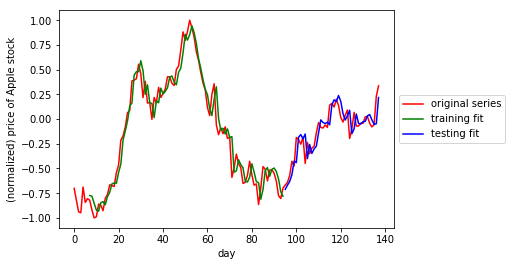

In [16]:
### Plot everything - the original series as well as predictions on training and testing sets
import matplotlib.pyplot as plt
%matplotlib inline

# plot original series
plt.plot(dataset,color = 'r')

# plot training set prediction
split_pt = train_test_split + window_size 
plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'g')

# plot testing set prediction
plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'b')

# pretty up graph
plt.xlabel('day')
plt.ylabel('(normalized) price of Apple stock')
plt.legend(['original series','training fit','testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()